In [1]:
import pandas as pd
import numpy as np
import gensim as gs
import simplejson as json
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
# from nltk import RegexpTokenizer

%matplotlib inline

E:\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


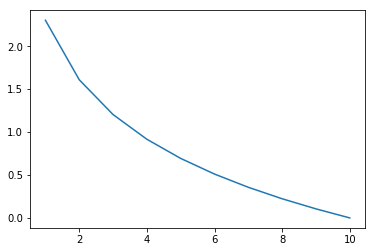

In [2]:
def idf(x):
    return np.log(10/x)

x = np.linspace(1,10,num=10)
plt.plot(x,idf(x))
plt.show()

In [3]:
class PreprocessIMDBData:
    def __init__(self):
        self.pattern = "[\w]+"
        self.stopword_set = set(stopwords.words('english'))
        
    def tokenizeSentence(self,text):
        tokenized_sentence = [w.lower() for w in nltk.regexp_tokenize(text,self.pattern)]
        cleanedSentence = list(set(tokenized_sentence).difference(self.stopword_set))
        return cleanedSentence

In [4]:
class VectorizeIMDBData:
    
    def __init__(self,tokenizerObj = PreprocessIMDBData()):
        self.tokenizerObj = tokenizerObj 
        self.tfidf = TfidfVectorizer(tokenizer=tokenizerObj.tokenizeSentence, ngram_range=(0, 1))
    
    def getTFIDFMatrix(self,docs):
        return self.tfidf.fit_transform(docs),self.tfidf.vocabulary_
    
    def getCleanedDocuments(self,docs, threshold = 0.6):
        scores,vocab = self.getTFIDFMatrix(docs)
        idf_inverse = 1/self.tfidf.idf_
        new_vocab_keys = (idf_inverse <= threshold)
        
        new_docs = []
        for doc_id,document in enumerate(docs):
            new_doc = []
            words = self.tokenizerObj.tokenizeSentence(document)
            for word in words:
                word_id  = vocab.get(word)
                if word_id is not None and new_vocab_keys[word_id]:
                    new_doc.append(word)
            
            cleanedDocument = ' '.join(new_doc)
            new_docs.append(cleanedDocument)
            
            del new_doc
        return new_docs
    
    def plot_words(self,threshold = [0.6]):
        max_figs_in_row = 5
        rows = int(np.ceil(len(threshold)/max_figs_in_row))
        cols  = np.minimum(len(threshold),max_figs_in_row)
        
        fig, axes = plt.subplots(rows, cols, figsize = (15, 9))
        
        vocab = self.tfidf.vocabulary_
        idf_inverse = 1/self.tfidf.idf_
        
        for i, ax in enumerate(fig.axes):
            frequencies = {}
            for key,value in vocab.items():
                if  value < len(idf_inverse) and idf_inverse[value] <= threshold[i]:
                    frequencies[key] = idf_inverse[value]
            
            if len(frequencies) <= 0:
                continue
            
            wc  = WordCloud(max_words=100)
            wc.generate_from_frequencies(frequencies)
            ax.imshow(wc, interpolation='bilinear')
            ax.set_axis_off()
        return

In [5]:
class Utils:
    
    @staticmethod
    def getGenres(genresStr):
        if pd.isnull(genresStr ):
            return []
        
        genresInStrList = []
        genreJson = json.loads(genresStr.replace("'",'"'))
        for genreObject in genreJson:
            genreName = genreObject['name'].lower()
            genresInStrList.append(genreName)
        
        return genresInStrList

In [6]:
mytokenizer = PreprocessIMDBData()
myTfIdfGenerator = VectorizeIMDBData(mytokenizer)

                                            #################  Test tf-idf and tokenizer
# docs = ["The sun is shining allowance", "The sun weather is sweet", "the is shining and the weather is sweet"]
# cleaned_docs = myTfIdfGenerator.getCleanedDocuments(docs,threshold=0.8)
# print(cleaned_docs)

In [7]:
movies_actual = pd.read_csv('./the-movies-dataset/movies_metadata.csv',low_memory=False)
cols = ['id','title','genres','overview']
movies_df_clean = movies_actual[cols]
movies_df_clean = movies_df_clean[pd.notnull(movies_df_clean['overview'])]
movies_df_clean.info()
del movies_actual

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44512 entries, 0 to 45465
Data columns (total 4 columns):
id          44512 non-null object
title       44506 non-null object
genres      44512 non-null object
overview    44512 non-null object
dtypes: object(4)
memory usage: 1.7+ MB


In [8]:
def datasetOverview(df):
    genre_count = 0
    word_count = 0
    for index,row in df.iterrows():
        movietags = Utils.getGenres( row['genres'])
        genre_count += len(movietags)
        words = mytokenizer.tokenizeSentence(row['overview'])
        word_count += len(words)
    
    print("Avg Genre :: ",(genre_count/len(df)))
    print("Avg Words :: ",(word_count/len(df)))
    return

datasetOverview(movies_df_clean)

Avg Genre ::  2.0226680445722502
Avg Words ::  29.3565106038821


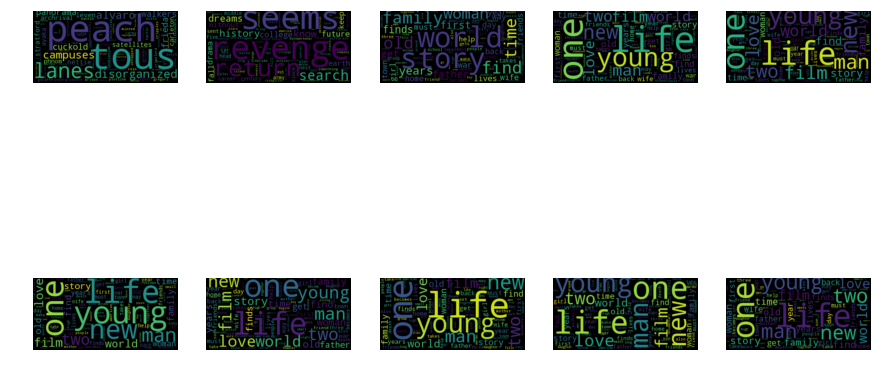

In [9]:
myTfIdfGenerator.getTFIDFMatrix(docs=list(movies_df_clean['overview']))
myTfIdfGenerator.plot_words(threshold=np.linspace(0.1,0.99,num=10))

In [10]:
overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = 0.6)
movies_df_clean['overview_cleaned'] = overview_cleaned

In [76]:
def plot_frequencies(movies_df_clean,cutoff = 0.00000001,columnName = 'overview',showGraph = False):
    mytokenizer = PreprocessIMDBData()
    genre_unkw = {}
    for index,row in movies_df_clean.iterrows():
        summary = set(mytokenizer.tokenizeSentence(row[columnName]))
        if len(summary) <= 0:
            continue
        
        genreList = Utils.getGenres(row['genres'])
        if len(genreList) <= 0:
            continue
        
        for genreObject in genreList:
            uniqueWords = set()
            if genreObject  in genre_unkw:
                uniqueWords = genre_unkw[genreObject]
            
            uniqueWords |= summary
            genre_unkw[genreObject] = uniqueWords
            
    uniqueWordsSet = set()    
    uniqueWordsDict = {}
    for genre,uniqueWords in genre_unkw.items():
        uniqueGenreRep_Count = len(uniqueWords)
        uniqueWordsSet |= uniqueWords
        if uniqueGenreRep_Count <= cutoff * len(movies_df_clean):
            continue
        
        uniqueWordsDict[genre] = uniqueGenreRep_Count
        uniqueWordsDict['VocabSize'] = len(uniqueWordsSet)
        
    df = pd.DataFrame.from_dict(uniqueWordsDict, orient='index')
    if showGraph:
        df.plot(kind='bar')
    
#     del uniqueWordsDict
#     del genre_unkw
    return df,uniqueWordsDict

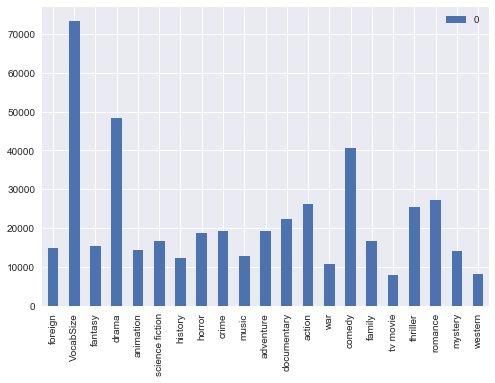

In [77]:
df,_ = plot_frequencies(movies_df_clean,cutoff = 0.1,showGraph=True)

In [78]:
thresholds=np.linspace(0.1,0.99,num=10)

plots_list = list()
for threshold in thresholds:
    print("Analyzing for threshold ",threshold)
    overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = threshold)
    movies_df_clean['overview_cleaned'] = overview_cleaned
    df,_ = plot_frequencies(movies_df_clean,cutoff=0.1,columnName='overview_cleaned')
    plots_list.append(df)
    print("Done with analysis")
print("------------->Done<-------------")

Analyzing for threshold  0.1
Done with analysis
Analyzing for threshold  0.198888888889
Done with analysis
Analyzing for threshold  0.297777777778
Done with analysis
Analyzing for threshold  0.396666666667
Done with analysis
Analyzing for threshold  0.495555555556
Done with analysis
Analyzing for threshold  0.594444444444
Done with analysis
Analyzing for threshold  0.693333333333
Done with analysis
Analyzing for threshold  0.792222222222
Done with analysis
Analyzing for threshold  0.891111111111
Done with analysis
Analyzing for threshold  0.99
Done with analysis
------------->Done<-------------


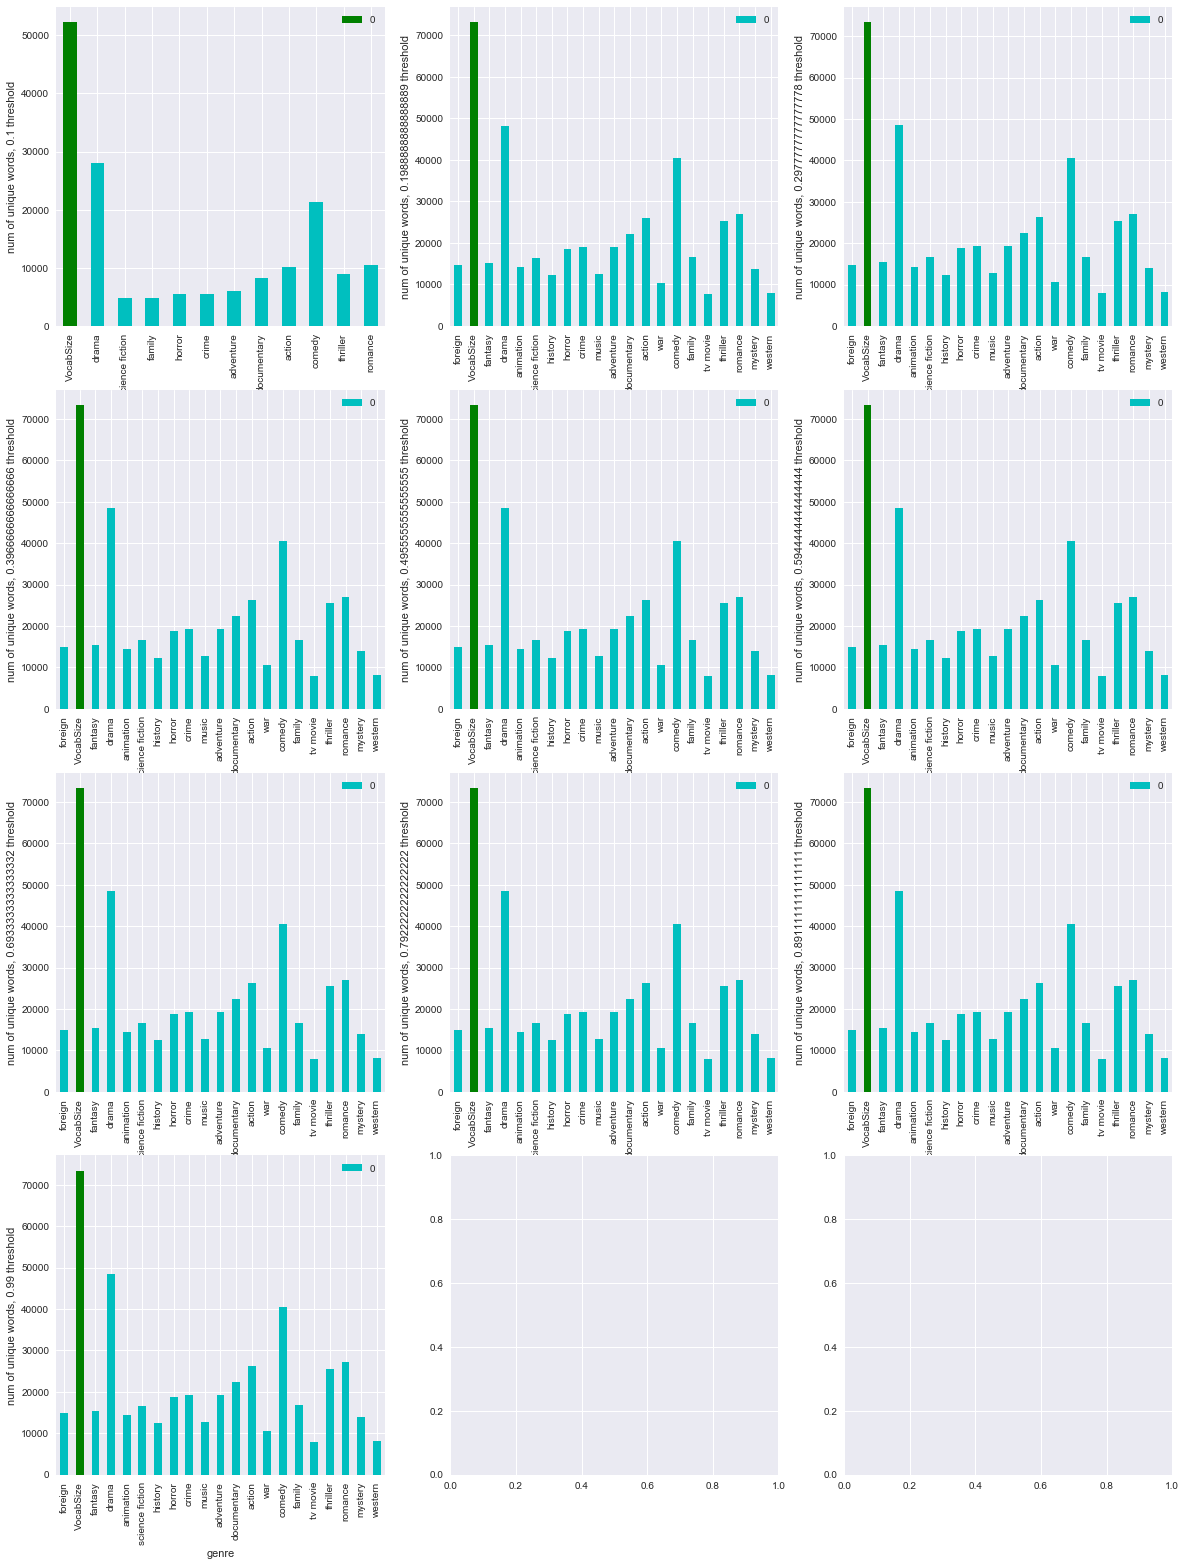

In [79]:
max_figs_in_row = 3
rows = int(np.ceil(len(plots_list)/max_figs_in_row))
cols  = np.minimum(len(plots_list),max_figs_in_row)

fig, axes = plt.subplots(rows, cols, figsize = (5*rows,9*cols))
for i, ax in enumerate(fig.axes):
    if i >= len(plots_list):
        continue
#     plots_list[i].plot(kind='bar',ax = ax)
    s = ['g' if index == 'VocabSize' else 'c' for index,value in plots_list[i][0].iteritems()]
    plots_list[i].plot(kind='bar',ax = ax,color = s)
    ax.set_xlabel("genre")
    ax.set_ylabel("num of unique words, {} threshold".format(thresholds[i]))

In [80]:
overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = 0.5)
movies_df_clean['overview_cleaned'] = overview_cleaned

In [81]:
_,uniqueGenres = plot_frequencies(movies_df_clean,cutoff=0.1,columnName='overview_cleaned')

# All genres have similar sentiments

In [16]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [82]:
class LabeledIMDBData(object):
    
    def __init__(self,df,considerTags = dict()):
        self.df = df
        self.tokenizer = PreprocessIMDBData()
        self.uniqueGenres = considerTags
        self.to_array()
    
    def __iter__(self):
        for movie_data in self.movies:
            yield movie_data
    
    def to_array(self):
        self.movies = []
        for index,row in self.df.iterrows():
            movietags = []
            tags = Utils.getGenres( row['genres'])
            if len(self.uniqueGenres) != 0:
                for tag in tags:
                    if tag in self.uniqueGenres:
                        movietags.append(tag)
            else:
                movietags = movietags + tags
            movietags.append(row['id'])
            movietags.append(row['title'])
            self.movies.append(TaggedDocument(words = self.tokenizer.tokenizeSentence(row['overview_cleaned']),
                                              tags = movietags))
        return self.movies
    
    def generate_permutations(self):
        from random import shuffle
        shuffle(self.movies)
        return self
    
    def datasetSize(self):
        return len(self.movies)
    
    def getVocabFreq(self):
        vocab = {}
        for movie_info in self:
            overview = movie_info.words
            for word in overview:
                freq = 0
                if word in vocab:
                    freq = vocab[word]
                freq = freq + 1
                vocab[word] = freq
            
            tags = movie_info.tags
            for tag in tags:
                freq = 0
                if tag in vocab:
                    freq = vocab[tag]
                freq = freq + 1
                vocab[tag] =  freq
        return vocab
    
    def slice_tags(self,tagToSearch):
        movies = []
        
        for movie in self:
            tags = movie.tags
            for tag in tags:
                if tag == tagToSearch:
                    movies.append(movie)
        return movies
    
    def slice_text(self,wordToSearch):
        movies = []
        
        for movie in self:
            overview = movie_info.words
            for word in overview:
                if word == wordToSearch:
                    movies.append(movie)
        return movies
        

In [83]:
cores = 1
simple_models = [
    # PV-DM w/ concatenation - window=5 (both sides) approximates paper's 10-word total window size
    Doc2Vec(dm=1, dm_concat=1, size=100, window=5, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DBOW 
    Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=1, workers=cores),
    # PV-DM w/ average
    Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores),
]

In [84]:
movies_df_clean.head()

,id,title,genres,overview,overview_cleaned
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",plots eventually room birthday owner duo aside...
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,adult world room creatures judy alan years tra...
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,interested feud opens scare fish reignites div...
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",man cheated vannah talk women bernie string ro...
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,change planning plan receives banks wedding ki...


In [100]:
movies_data = LabeledIMDBData(movies_df_clean,uniqueGenres)  ## Small dataset
# movies_data = LabeledIMDBData(movies_df_clean)
model = Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=1, workers=cores)
# model.delete_temporary_training_data()
# model.build_vocab_from_freq(movies_data.getVocabFreq())
model.build_vocab(movies_data.to_array())
# model.raw_vocab

In [116]:
uniqueGenres.keys()

dict_keys(['foreign', 'VocabSize', 'fantasy', 'drama', 'animation', 'science fiction', 'history', 'horror', 'crime', 'music', 'adventure', 'documentary', 'action', 'war', 'comedy', 'family', 'tv movie', 'thriller', 'romance', 'mystery', 'western'])

In [103]:
alpha, min_alpha, passes = (0.025, 0.001, 20)
alpha_delta = (alpha - min_alpha) / passes

for epoch in range(passes):
    print("Now at epoch number ",(epoch+1)," out of total number of epoch ",passes)
    
    model.alpha, model.min_alpha = alpha, alpha
    model.train(movies_data.generate_permutations(), total_examples=movies_data.datasetSize(), epochs=1)
    model.alpha -= alpha_delta
#     print(model.corpus_count)
    
print("------------->Done with training<----------------------")

Now at epoch number  1  out of total number of epoch  20
Now at epoch number  2  out of total number of epoch  20
Now at epoch number  3  out of total number of epoch  20
Now at epoch number  4  out of total number of epoch  20
Now at epoch number  5  out of total number of epoch  20
Now at epoch number  6  out of total number of epoch  20
Now at epoch number  7  out of total number of epoch  20
Now at epoch number  8  out of total number of epoch  20
Now at epoch number  9  out of total number of epoch  20
Now at epoch number  10  out of total number of epoch  20
Now at epoch number  11  out of total number of epoch  20
Now at epoch number  12  out of total number of epoch  20
Now at epoch number  13  out of total number of epoch  20
Now at epoch number  14  out of total number of epoch  20
Now at epoch number  15  out of total number of epoch  20
Now at epoch number  16  out of total number of epoch  20
Now at epoch number  17  out of total number of epoch  20
Now at epoch number  18

In [104]:
model.save('./models/imdb.d2v')
model.save_word2vec_format('./models/word2vecformat.nn')

In [105]:
doc_id = str(862)
sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)  # get *all* similar documents
print(u'TARGET (%s): «%s»\n' % (doc_id, ' '.join(movies_data.slice_tags(doc_id)[0].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(movies_data.slice_tags(doc_id)[0].words)))

TARGET (862): «plots eventually room birthday owner duo aside brings onto scene afraid led differences losing happily woody put place live separate andy buzz lightyear learns heart circumstances toys»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dbow,d100,n5,s0.001):

MOST ('Toy Story', 0.9823046326637268): «plots eventually room birthday owner duo aside brings onto scene afraid led differences losing happily woody put place live separate andy buzz lightyear learns heart circumstances toys»

MEDIAN ('42455', 0.24788621068000793): «plots eventually room birthday owner duo aside brings onto scene afraid led differences losing happily woody put place live separate andy buzz lightyear learns heart circumstances toys»

LEAST ('Bayou Blue', -0.1750205159187317): «plots eventually room birthday owner duo aside brings onto scene afraid led differences losing happily woody put place live separate andy buzz lightyear learns heart circumstances toys»



In [106]:
doc_id = ('animation')
sims = model.docvecs.most_similar(doc_id, topn=20)
sims

[('50087', 0.6794806122779846),
 ('Pokémon: Zoroark: Master of Illusions', 0.6742199063301086),
 ('Agent F.O.X.', 0.6705284714698792),
 ('Scooby-Doo! and the Goblin King', 0.6625484228134155),
 ('276678', 0.6584944725036621),
 ('12903', 0.6566243171691895),
 ('Scooby-Doo! and the Cyber Chase', 0.6546036005020142),
 ('Justice League: War', 0.6525707244873047),
 ('Rakuen Tsuihou - Expelled from Paradise', 0.6500539779663086),
 ('Cosmic Scrat-tastrophe', 0.6497523784637451),
 ('15601', 0.6442418694496155),
 ('Pokémon the Movie: Hoopa and the Clash of Ages', 0.6413623690605164),
 ('The Land Before Time XI: Invasion of the Tinysauruses', 0.6408331394195557),
 ('24556', 0.6370759010314941),
 ('304023', 0.6356580853462219),
 ('LEGO DC Comics Super Heroes: Justice League vs. Bizarro League',
  0.6349764466285706),
 ('45162', 0.6331504583358765),
 ('Justice League: The New Frontier', 0.6331369876861572),
 ('Storks', 0.6320940852165222),
 ('Ratchet & Clank', 0.631862998008728)]

In [107]:
doc_id = ('comedy')
sims = model.docvecs.most_similar(doc_id, topn=20)
sims

[('Fired Up!', 0.6117886304855347),
 ('198308', 0.6071131229400635),
 ('17927', 0.6057482957839966),
 ('The Apple Game', 0.605218768119812),
 ('Zombies on Broadway', 0.6047451496124268),
 ('30183', 0.6001530885696411),
 ('Ricky Gervais Live 3: Fame', 0.598109245300293),
 ('198306', 0.5939569473266602),
 ('44706', 0.5916987657546997),
 ("Norm Macdonald: Hitler's Dog, Gossip & Trickery", 0.5906237363815308),
 ('370260', 0.5898975729942322),
 ('The Bet', 0.5890280604362488),
 ('43819', 0.5885580778121948),
 ('10792', 0.588137149810791),
 ('Ricky Gervais Live: Animals', 0.5878844857215881),
 ('One Night Only', 0.5870063304901123),
 ('Dylan Moran: Off The Hook', 0.5861377120018005),
 ('90806', 0.5855062007904053),
 ('401442', 0.583831787109375),
 ('176545', 0.583538830280304)]

In [108]:
model.most_similar(['wedding','opens'])

[('eyesore', 0.41907501220703125),
 ('arguable', 0.39534130692481995),
 ('gitów', 0.3919023871421814),
 ('aggressions', 0.38342562317848206),
 ('lhadatt', 0.38319122791290283),
 ('964', 0.3750830590724945),
 ('belham', 0.3746144771575928),
 ('tad', 0.36939769983291626),
 ('yuwen', 0.3668549060821533),
 ('unsettling', 0.3609676957130432)]

In [109]:
model.docvecs.similarity('romance','animation')

0.21952517911064418

In [110]:
model.docvecs.similarity('drama','family')

0.28486542327571551

In [111]:
genres = set()
for idx,row in movies_df_clean.iterrows():
    genres |= set(Utils.getGenres(row['genres']))

genres = list(genres)

In [117]:
from itertools import permutations

genreSimDict = {}
for genreSublist in permutations(genres,2):
    genreOne = genreSublist[0]
    genreTwo = genreSublist[1]
    if genreOne not in uniqueGenres or genreTwo not in uniqueGenres:
        continue
    try:
        similarity_score = model.docvecs.similarity(genreOne,genreTwo)
    except:
        pass
    genreSimDict[genreSublist] = similarity_score
#     if similarity_score< 0.3:
#         continue
#     print("Similarity between %s,%s is %f\n" % (genreOne,genreTwo,similarity_score))
ser = pd.Series(list(genreSimDict.values()),
                  index=pd.MultiIndex.from_tuples(genreSimDict.keys()))
df = ser.unstack().fillna(0)
df.shape

(20, 20)

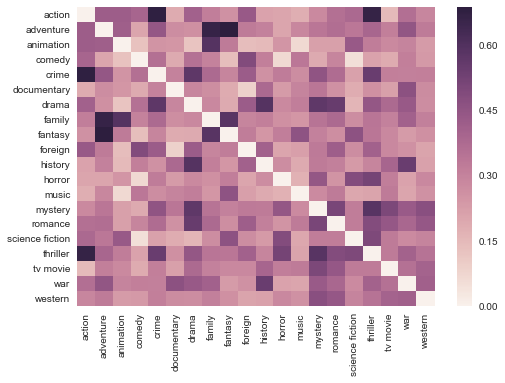

In [118]:
import seaborn as sns
sns.heatmap(df);

In [114]:
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel

# sentenceTokenizer = PreprocessIMDBData()
# movies = movies_df_clean['overview_cleaned'].values
# movie_tokenized = [sentenceTokenizer.tokenizeSentence(movie) for movie in movies]
# dictionary = corpora.Dictionary(movie_tokenized)
# doc_term_matrix = [dictionary.doc2bow(movie) for movie in movie_tokenized]

In [115]:
# ldamodel = LdaModel(doc_term_matrix,num_topics=10,id2word=dictionary,passes= 20,alpha=0.3,eta=0.7)

In [ ]:
# print(ldamodel.print_topics(num_topics=10,num_words=3))